In [1]:
import os
import torch
from torch.autograd import Variable

import time
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from collections import OrderedDict

os.chdir("..")

from GaLa_v5 import llaplace
from NN import DNN_Ensemble,DNN,Dropout_DNN

np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Burgers Equation

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} - \frac{0.01}{\pi}\frac{\partial^{2} u}{\partial x^{2}}=0$$
$$u(x,0) = -sin( \pi x),  u(-1,t)=u(1,t)=0$$

# SIREN 

In [2]:
class SineLayer(torch.nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = torch.nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
class Siren(torch.nn.Module):
    def __init__(self, layers,  
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.depth = len(layers) - 1
        self.net = []
        self.net.append(SineLayer(layers[0], layers[1], 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(1,self.depth - 1):
            self.net.append(
                SineLayer(layers[i], layers[i+1], 
                                      is_first=False, omega_0=hidden_omega_0))

        final_linear = torch.nn.Linear(layers[-2], layers[-1])
        
        with torch.no_grad():
            final_linear.weight.uniform_(-np.sqrt(6 / layers[-2]) / hidden_omega_0, 
                                            np.sqrt(6 / layers[-2]) / hidden_omega_0)
            
            self.net.append(final_linear)

        
        self.net = torch.nn.Sequential(*self.net)
    
    def forward(self, coords):
        #coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        #return output, coords        
        return output

In [3]:
def de(self,data_domain):
    """ The pytorch autograd version of calculating residual """
    u = self(data_domain)
    
    du = torch.autograd.grad(
        u, data_domain, 
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    f = du[:,1].reshape(-1,1) + u.reshape(-1,1)*du[:,0].reshape(-1,1) - data_domain[:,2].reshape(-1,1)*ddu_x[:,0].reshape(-1,1)

    return f

def ini_c(self,data_inic):
    u = self(data_inic)
    return u + torch.sin(torch.pi*data_inic[:,0].reshape(-1,1))

def left_bc(self,data_lbc):
    u = self(data_lbc)
    return u

def right_bc(self,data_rbc):
    u = self(data_rbc)
    return u

In [4]:
Siren.de = de
Siren.ini_c = ini_c
Siren.left_bc = left_bc
Siren.right_bc = right_bc

In [5]:
def samples_space(size,maxl=1):
    t_f_train = lhs(2, size)*maxl
    t_f_train[:,0] = t_f_train[:,0]*(2)-1
    t_f_train[:,1] = t_f_train[:,1]*(0.5)
    return t_f_train

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [6]:
def data_pde(size,minp,maxp):

    xy, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xy,param.reshape(-1,1)))).float()
    
    x,y, param  = torch.tensor(xy[:,0]).reshape(-1,1),torch.tensor(xy[:,1]).reshape(-1,1),torch.tensor(param).reshape(-1,1)

    ini_c = torch.cat([x,torch.zeros_like(x).float(),param],axis = 1).float()

    left_bc = torch.cat([torch.ones_like(x).float()*(-1),y, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(x).float(),y, param],axis = 1).float()

    return pde_domain,ini_c,left_bc,right_bc

In [7]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      for i in range(epochs):
        pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        
        pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
                loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

                Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc
                train_loss.append(Loss.item())
                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                                         Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))
                                
                Loss.backward() 

                optimizer.step() 

                #sheduler.step()
      return train_loss

In [8]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100, minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,ini_c,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    
    pde_domain,ini_c = Variable(pde_domain,requires_grad=True),Variable(ini_c,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred,ini_c_pred = pinn.de(pde_domain), pinn.ini_c(ini_c)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        loss_pde,loss_ini = loss(pde_pred,torch.zeros_like(pde_pred)),loss(ini_c_pred,torch.zeros_like(pde_pred))
        loss_lbc,loss_rbc = loss(left_bc_pred,torch.zeros_like(pde_pred)),loss(right_bc_pred,torch.zeros_like(pde_pred))

        Loss =  loss_pde + loss_ini + loss_lbc + loss_rbc
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_PDE: %.5e, Loss_ini: %.5e, Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                                            Loss.item(),loss_pde.item(),loss_ini.item(), loss_lbc.item(), loss_rbc.item()))

        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [16]:
# Number of observations
epochs = 100000
nobs = 3000
#nobs = 500
lr = 0.001

min_param , max_param = 0.0001, 0.05

layers = [3] + 3*[40] + [1]

model = Siren(layers,first_omega_0=8, hidden_omega_0=8)

In [17]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(model.parameters(), lr = lr)

loss_history = train_adam(model,loss,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(
#     model.parameters(), lr=lr, max_iter=50000, max_eval=None, tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,line_search_fn="strong_wolfe" 
#     )

# loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 6.63312e-01, Loss_PDE: 2.22949e-02, Loss_ini: 6.24638e-01, Loss_lbc: 1.37730e-02,Loss_rbc: 2.60631e-03
Iter 10, Loss: 1.15933e-01, Loss_PDE: 3.71440e-02, Loss_ini: 7.12527e-02, Loss_lbc: 3.40756e-03,Loss_rbc: 4.12877e-03
Iter 20, Loss: 6.30324e-02, Loss_PDE: 2.45883e-02, Loss_ini: 3.41560e-02, Loss_lbc: 4.13714e-03,Loss_rbc: 1.50990e-04
Iter 30, Loss: 4.75183e-02, Loss_PDE: 2.62620e-02, Loss_ini: 2.03383e-02, Loss_lbc: 7.82232e-04,Loss_rbc: 1.35692e-04
Iter 40, Loss: 4.31387e-02, Loss_PDE: 2.47595e-02, Loss_ini: 1.76277e-02, Loss_lbc: 4.60891e-04,Loss_rbc: 2.90573e-04
Iter 50, Loss: 3.90151e-02, Loss_PDE: 2.04542e-02, Loss_ini: 1.83030e-02, Loss_lbc: 1.73790e-04,Loss_rbc: 8.41910e-05
Iter 60, Loss: 3.67227e-02, Loss_PDE: 2.21866e-02, Loss_ini: 1.43158e-02, Loss_lbc: 1.86057e-04,Loss_rbc: 3.42720e-05
Iter 70, Loss: 3.33407e-02, Loss_PDE: 1.55057e-02, Loss_ini: 1.76281e-02, Loss_lbc: 1.84684e-04,Loss_rbc: 2.22402e-05
Iter 80, Loss: 3.20600e-02, Loss_P

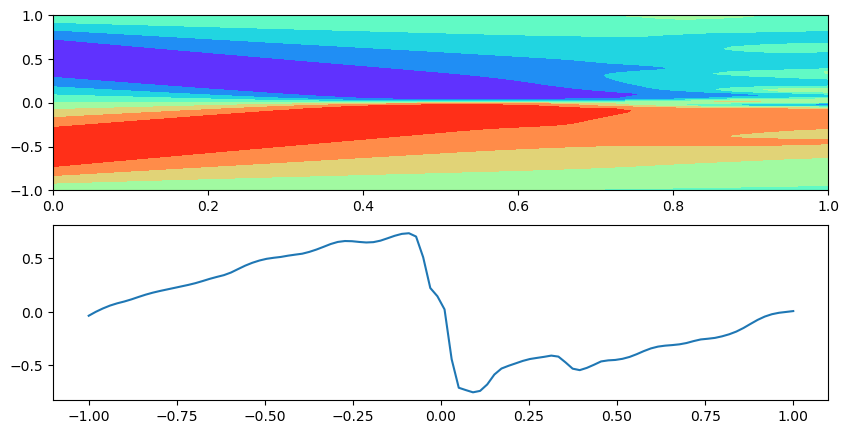

In [18]:
x = np.linspace(-1,1,100)
y = np.linspace(0,1,100)

xx, yy = np.meshgrid(x, y)
xx, yy = torch.tensor(xx).reshape(-1,1).float(),torch.tensor(yy).reshape(-1,1).float()


X_star = torch.cat([xx,yy,torch.ones_like(xx)*(0.01)],axis = 1)
mean = model(X_star)

fig, axs = plt.subplots(2,1, figsize=(10, 5))

xx,yy = np.meshgrid(x, y)

U_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean.flatten().detach().numpy(), (xx,yy), method='cubic')
#U_sigma = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std[:,0], (xx,yy), method='cubic')

axs[0].contourf(y.flatten(), x.flatten(), U_pred.T,cmap='rainbow')

axs[1].plot(x,U_pred[75,:])
#axs[1].fill_between(x.reshape(-1), U_pred[75,:]+U_sigma[75,:],U_pred[75,:]-U_sigma[75,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
